<a id="toc"></a>

# <u>Table of Contents</u>

1.) [Setup](#setup)  
&nbsp;&nbsp;&nbsp;&nbsp; 1.1.) [Imports](#imports)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.2.) [Helpers](#helpers)   
&nbsp;&nbsp;&nbsp;&nbsp; 1.3.) [Load data](#load)   
2.) [Datetime](#datetime)  
3.) [Speakers](#speakers)  
4.) [Transcript](#transcript)  
5.) [Save to CSV](#save)  

---
<a id="setup"></a>

# [^](#toc) <u>Setup</u>

<a id="imports"></a>

### [^](#toc) Imports

In [1]:
### Standard imports
import pandas as pd
import numpy as np

### Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import re
import datetime

# Helps convert String representation of list into a list
import ast

### Removes warnings that occassionally show in imports
import warnings
warnings.filterwarnings('ignore')

<a id="helpers"></a>

### [^](#toc) Helpers

In [2]:
def string_literal(x):
    try:
        return ast.literal_eval(x)
    except:
        return x

<a id="load"></a>

### [^](#toc) Load data

In [3]:
df = pd.read_csv("../data/PBS_full_unedited.csv")
for col in ["Transcript", "Story", "Speakers"]:
    df[col] = df[col].map(string_literal)
    
print("Shape of df:", df.shape)
df.head()

Shape of df: (17617, 7)


,URL,Story,Date,Title,Transcript,Speakers,Number of Comments
0,https://www.pbs.org/newshour/show/news-wrap-tr...,"In our news wrap Monday, President Trump's sea...","Jul 2, 2018 6:50 PM EDT",News Wrap: Trump interviews Supreme Court cand...,"[[Judy Woodruff, [ President Trump’s search fo...","{President Donald Trump, Justin Herdman, Judy ...",0.0
1,https://www.pbs.org/newshour/show/elected-in-a...,Mexican president-elect Andrés Manuel López Ob...,"Jul 2, 2018 6:45 PM EDT","Elected by a landslide, can Mexico’s López Obr...","[[Judy Woodruff, [ After two previous runs for...","{Marcos Fastlicht, Andres Manuel Lopez Obrador...",0.0
2,https://www.pbs.org/newshour/show/will-u-s-mex...,There are enormous expectations facing the new...,"Jul 2, 2018 6:43 PM EDT",Will U.S.-Mexico policy tensions change under ...,"[[Judy Woodruff, [ And now perspective from fo...","{Judy Woodruff, Roberta Jacobson}",0.0
3,https://www.pbs.org/newshour/show/yemens-spira...,One of the poorest countries in the Middle Eas...,"Jul 2, 2018 6:40 PM EDT",Yemen’s spiraling hunger crisis is a man-made ...,"[[Judy Woodruff, [ The “NewsHour” has reported...","{Lise Grande, Stephen Anderson, Naimi (through...",0.0
4,https://www.pbs.org/newshour/show/livingwhileb...,A profusion of national incidents in which whi...,"Jul 2, 2018 6:35 PM EDT",#LivingWhileBlack: How does racial bias lead t...,"[[Judy Woodruff, [ A number of recent incident...","{Woman, Judy Woodruff, Yamiche Alcindor, Derri...",0.0


---
<a id="datetime"></a>

# [^](#toc) <u>Datetime</u>

First let's clear off whitespace and \n characters

In [4]:
df["Date"] = df["Date"].map(lambda x: x.strip())

### Time Zone

It appears, the time is always posted in EDT

In [5]:
df["Timzone"] = df.Date.map(lambda x: x[-3:])
df["Timzone"].value_counts()

EDT    17617
Name: Timzone, dtype: int64

### Updated times

There are only 4 videos that were updated.  I don't think this is very interesting so I'm just going to ignore all updated times.

I understand why someone would like this data, but I don't need it.

In [6]:
df.temp = df.Date.map(lambda x: int("Updated" in x))
num_updated = len(df[df.temp == 1])
print(f"{num_updated} clips have had information updated")

df.Date = df.Date.map(lambda x: x.split("\n")[0])

4 clips have had information updated


### Convert to Datetime

See this Stack Exchange [link](https://english.stackexchange.com/questions/35315/what-is-the-proper-name-for-am-and-pm?newreg=2d443a2ca9dc4ba6abbe1a1e01e4af4b) haha.  I was honored by the line...

    software developers think about naming variables properly. It is built into the Object-Oriented mindset. Jader, a commenter, said it well: "It's funny that the question intrinsically is not programming related, but all programmers can understand why you posted it here."
    
I just considered myself a physicist!

In [7]:
def format_datetime(x):
    return datetime.datetime.strptime(x[:-4], '%b %d, %Y %H:%M %p')

df.Date = df.Date.map(format_datetime)

### And we're done with times!

---
<a id="speakers"></a>

# [^](#toc) <u>Speakers</u>

### Fill in missing speakers

In [8]:
for row in df.loc[df.Speakers.isnull(), 'Speakers'].index:
    df.at[row, 'Speakers'] = {}

### Overview of names

In [9]:
N = len(set.union(*df.Speakers))

print("Unique names found in df:", N)

Unique names found in df: 32725


### Example: Obama

It looks like there's a lot to do here, I want uniform names.

When I search for Obama I want to see 'SEN. BARACK OBAMA', 'SENATOR BARACK OBAMA', 'PRESIDENT BARACK OBAMA', 'PRESIDENT BARACK OBAMA (singing)', 'BARACK OBAMA', 'BARACK OBAMA (singing)', and 'Barack Obama'

My plan of attack is

However removing modifiers only goes so far, sometimes the names are shortened.  In which case I need to manually group "Obama" and "PRESIDENT OBAMA" to "BARACK OBAMA".

There also seems to be ASCII errors like "\xa0" popping up.

In [10]:
{elem for elem in {x for x in set.union(*df.Speakers)} if ("OBAMA" in elem or "Obama" in elem or "obama" in elem)}

{'And I think Obama and Boehner and Reid all know that their legacies are tied together and they reside around one thing',
 'And Obama’s counter will have to be',
 'And President Obama says he will do something few presidents have done',
 'And so that’s what the FTC and the Obama Administration have both called for',
 'Arizona Senator John McCain said today the Obama administration is to blame',
 'BARACK OBAMA',
 'BARACK OBAMA (singing)',
 'Barack Obama',
 'Before a fund-raiser for President Obama',
 'Brookings institution scholar Shadi Hamid credits Mr. Obama for the Iran deal',
 'But the Obama reelection team did wade into the Bain debate with a memo that said',
 'Daniel Benjamin was coordinator for counterterrorism at the State Department during the first term of the Obama administration. He’s now a professor at Dartmouth College. And Joby Warrick is a national security correspondent at The Washington Post. He’s also the author of the book “Black Flags',
 'FIRST LADY MICHELLE OBAMA'

### Long names are actually text

In [11]:
df.Speakers = df.Speakers.map(lambda x: {elem for elem in x if len(elem.split(" ")) < 9})

### Remove titles, parties, and non-name features

We went from 32,725 names to 27,188 names.  This is either from dropping bad names or merging two names that are actually the same person.

This is not perfect, PBS does not have a standardized format.  PBS is not considerate of robots as this [example](https://www.pbs.org/newshour/show/trump-considering-sending-troops-afghanistan) shows.  The names start out as full names, but than move to last names.  This makes complete sense to a human in context.  I can't get a machine to understand context though.  Thankfully this type of format is rare and "SREENIVASAN" is a rare name so I can map it to "HARI SREENIVASAN".  "RUBIN" is probably a more common name and less popular on PBS newshour so unfortunately there's nothing I can easily do.

In [12]:
%run preprocessing.py
%run mistaken_names.py

mistaken_names = get_mistaken_names()

def map_speakers(x):
    return {clean_names(elem) for elem in x if clean_names(elem) not in mistaken_names}

df.Speakers = df.Speakers.map(map_speakers)
N = len(set.union(*df.Speakers))
print("New number of unique names:", N)

New number of unique names: 27187


### Quick Visualization

There might be more work needed to be done.  I don't know why "S", "T", or "E" are all names.

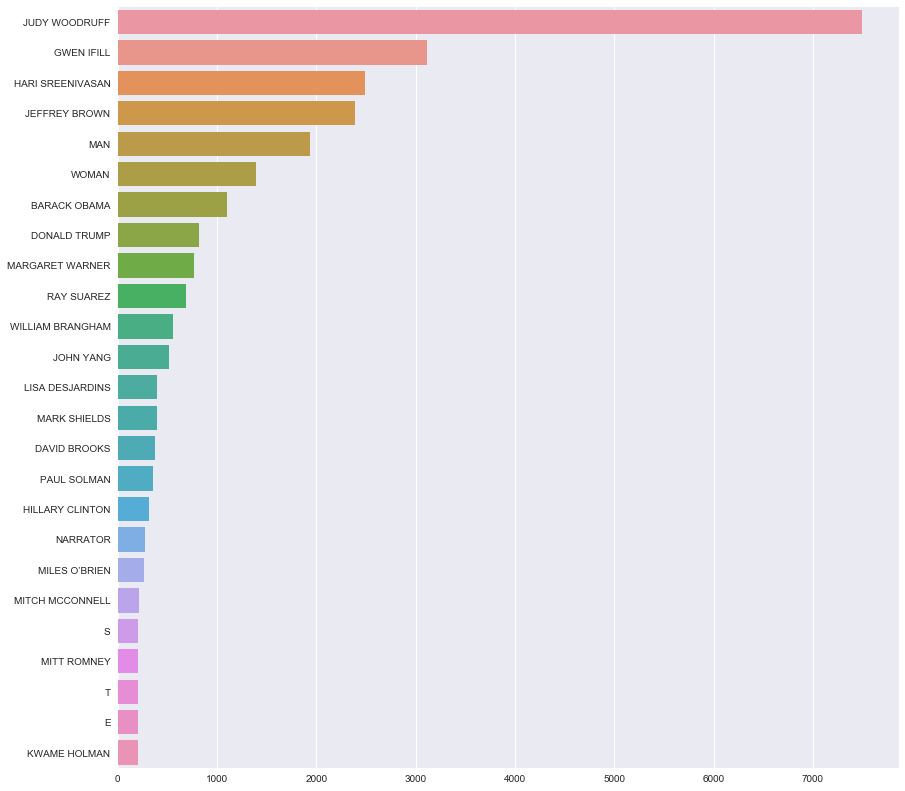

In [13]:
# Will count number of unique words in a sentence
from collections import Counter
import operator
    
persons = df.Speakers.map(list).sum()

freq = sorted(Counter(persons).items(), key=operator.itemgetter(1), reverse=True)

x, y = list(zip(*freq[:25]))
plt.figure(figsize=(14, 14))
sns.barplot(list(y), list(x));

---
<a id="transcript"></a>

# [^](#toc) <u>Transcript</u>

In [14]:
for row in df.loc[df.Transcript.isnull(), 'Transcript'].index:
    df.at[row, 'Transcript'] = []

### Plan of attack

1.) Remove all speakers that should not be included.  
2.) Go through each Transcript and check if it has a Speaker that is not included.  
3.) If this speaker is the first one talking, print the URL and clip this short.  
4.) If the speaker is nnot the first talker, print the URL and append the speaker and text to the previous speaker.  
- Check out this [video](https://www.pbs.org/newshour/show/with-3-more-wins-romney-pivots-to-general-election#transcript) and search for "North Carolina is a strong one for them".  You'll see one of these formating slips.

In [15]:
def map_transcript(speakers):
    def map_transcript_helper(x):
        if x is np.nan:
            return x
        i = 0
        while i < len(x):
            speeches = x[i]
            
            if clean_names(speeches[0]) not in speakers:
                if i == 0:
                    x = x[1:]
                else:
                    temp = speeches[1][:]
                    temp.insert(0, speeches[0])
                    x[i-1][1] = x[i-1][1] + temp

                    del x[i]
                    i -= 1
            i += 1
        return x
    return map_transcript_helper

speakers = set.union(*df.Speakers)
df.Transcript = df.Transcript.map(map_transcript(speakers))

### Quick check

I'll check a few random transcripts to see if they were formatted correctly

And wow!  This works almost perfectly!  I haven't seen one mistake yet

In [16]:
### Used to style Python print statements
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def pretty_transcript(transcript, convert_name=False):
    print(color.BOLD, "TRANSCRIPT", color.END)
    for speaker in transcript:
        if convert_name:
            speaker[0] = clean_names(speaker[0])
        print(color.UNDERLINE, speaker[0] + ":", color.END)
        for txt in speaker[1:]:
            print("  ", " ".join(txt))
        print()
            
for _ in range(5):
    print()
    index = np.random.randint(0, len(df) - 1)
    print(df.iloc[index].URL)
    pretty_transcript(df.iloc[index].Transcript, convert_name=True)


https://www.pbs.org/newshour/show/mitt-romney-and-president-obama-to-square-off-in-debate
 TRANSCRIPT 
 JUDY WOODRUFF: 
    In just a few hours, President Barack Obama and former Massachusetts Governor Mitt Romney will take the stage at the University of Denver’s Magness Arena for the first of three election debates.

 TONIGHT’S ENCOUNTER: 
    the economy. Joining us for the debate later and here with us now to preview what to expect tonight, two familiar faces, syndicated columnist Mark Shields and New York Times columnist David Brooks. Gentlemen, welcome. The night is finally here. Mark, no pressure, just 60 million people will be watching. What are you looking for from tonight’s encounter?

 MARK SHIELDS: 
    What I’m looking for, Judy, is that the — the candidate who understands of the two that the most important thing is not making a mistake, but really making a point as to what his presidency would be about. And I think that’s — I think both of them are geared, because so much

# Misc cleaning

### Order dataframe

In [21]:
df = df.sort_values("Date").reset_index(drop=True)
df.head()

,URL,Story,Date,Title,Transcript,Speakers,Number of Comments,Timzone
0,https://www.pbs.org/newshour/show/robert-macne...,“How high did the scandals reach and was Presi...,1973-05-17 02:26:00,Watergate: The NewsHour’s 1973 Special Report,[],"{S, T, E}",0.0,EDT
1,https://www.pbs.org/newshour/show/tempers-flar...,This MacNeil/Lehrer Report piece highlights th...,1979-06-29 06:00:00,Tempers Flare In Lines for Gasoline in 1979,[],"{S, T, E}",0.0,EDT
2,https://www.pbs.org/newshour/show/margaret-tha...,Robert MacNeil and Jim Lehrer interviewed Brit...,1981-02-27 06:00:00,Newsmaker: Margaret Thatcher,[],"{S, T, E}",0.0,EDT
3,https://www.pbs.org/newshour/show/macneil-lehr...,Jim Lehrer and Charlene Hunter Gault report on...,1982-10-25 06:00:00,"The MacNeil/Lehrer Report – October 25, 1982 –...",[],"{S, T, E}",0.0,EDT
4,https://www.pbs.org/newshour/show/the-macneil-...,Robert MacNeil and Charlayne Hunter Gault repo...,1983-11-30 06:00:00,"The MacNeil/Lehrer Report from Nov. 30, 1983 o...",[],"{S, T, E}",0.0,EDT


### Remove Speakers if missing Transcript

In [44]:
temp = df.Transcript.map(lambda x: x != []).index
df.at[temp, "Speakers"] = [{} for _ in range(len(temp))]

df[df.Transcript.map(lambda x: x == []) & df.Speakers.map(lambda x: x != {})]

,URL,Story,Date,Title,Transcript,Speakers,Number of Comments,Timzone


---
<a id="save"></a>

# [^](#toc) <u>Save to CSV</u>

Now that we've cleaned up our data a bit, let's save it into a different CSV file.

In [45]:
df.to_csv("../data/PBS-newhour-clean.csv", index=False)

# Tests

### Remove party regex

In [18]:
%run preprocessing.py

ex1 = "BARBARA MIKULSKI (D-MD.)"
assert remove_party(ex1) == "BARBARA MIKULSKI" 

ex2 = "JERRY BROWN (D-CALIF.)"
assert remove_party(ex2) == "JERRY BROWN" 

ex3 = "CHUCK SCHUMER (DN.Y.)"
assert remove_party(ex3) == "CHUCK SCHUMER" 

ex4 = "JOHN BOEHNER (R-OH.)"
assert remove_party(ex4) == "JOHN BOEHNER" 

ex5 = "JEFF SESSIONS (R-ALA.)"
assert remove_party(ex5) == "JEFF SESSIONS" 

ex6 = "TODD YOUNG (RIND.)"
assert remove_party(ex6) == "TODD YOUNG" 

ex7 = "DONALD TRUMP"
assert remove_party(ex7) == ex7

ex8 = "PRESIDENT BARACK OBAMA (singing)"
assert remove_party(ex8) == ex8